# CONTROLLABILITY


**START LOOKING FOR A MODEL TO ANALYZE AND CONTROL**

Recommend that you use [BioModels](https://www.ebi.ac.uk/biomodels/search?query=*%3A*+AND+curationstatus%3A%22Manually+curated%22&domain=biomodels).

<img src="https://raw.github.com/joseph-hellerstein/advanced-controls-lectures/main/lectures/images/biomodels_search.png"
     alt="Markdown Monster icon"
     width="1000" height="240"
     style="float: left; margin-right: 10px;" />

In [27]:
!pip install -q tellurium
!pip install -q controlSBML

In [2]:
import tellurium as te
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional

# Helpers

In [3]:
TEST_MODEL = """
S1 -> S2; k1*S1
S2 -> ; k2*S2

$S1 = 10
k1 = 1
k2 = 1
S2 = 0
"""

In [4]:
# Function that adjust model parameters
def plotModel(model, title="", is_plot=True, input_species=None,
              times=np.linspace(0, 5, 50), selections=None, figsize=(4,4), parameter_dct:Optional[dict]=None):
    """
    Plots the simulation with the specified parameter values.

    Parameters
    ----------
    model: str either antimony or URL
    title: str (plot title)
    is_plot: bool
    input_species: str (species used as input if it is not a boundary/fixed species in the model)
    times: array-float (times for simulations)
    selections: list-str (species to plot)
    figsize: int, int (dimensions of the figure)
    parameter_dct: specification of values in the model
        key: parameter name
        value: parameter value

    Returns
    -------
    NamedArray
    """
    if "http" in model:
        rr = te.loadSBMLModel(model)
    else:
        rr = te.loada(model)
    if input_species is not None:
        rr.setBoundary(input_species, True)
    if selections is not None:
        new_selections = list(selections)
        if not "time" in selections:
            new_selections.insert(0, "time")
    else:
        new_selections = selections
    if parameter_dct is not None:
        for name, value in parameter_dct.items():
            rr[name] = value
    simulation_results = rr.simulate(times[0], times[-1], len(times), selections=new_selections)
    _, ax = plt.subplots(1, figsize=figsize)
    columns = simulation_results.colnames
    columns = columns[1:]
    for column in columns:
        if column == "time":
            next
        ax.plot(simulation_results[:, 0], simulation_results[column])
    plt.legend(columns)
    ax.set_xlabel("time")
    ax.set_title(title)
    if is_plot:
        plt.show()
    return simulation_results

# TESTS
results = plotModel(TEST_MODEL, input_species="S1", figsize=(4,4), is_plot=False, parameter_dct={'S1': 4})
assert("NamedArray" in str(type(results)))
plt.close()
print("OK")

OK


# Controllability

<img src="https://raw.github.com/joseph-hellerstein/advanced-controls-lectures/main/lectures/images/simple_closed_loop.png"
     alt="Markdown Monster icon"
     width="800" height="240"
     style="float: left; margin-right: 10px;" />

Consider a system with input $u(t)$ and output $y(t)$ that we want to regulate over the region $y_L \leq y(t) \leq y_H$. The system is controllable if there are values of $u(t)$ such that $y(t)$ can achieve the desired values.

Note the use of ``$`` for species ``S1``. This indicates a **fixed species**, one whose value does not change.

In [5]:
MODEL1 = """
S1 -> S2; k1*S1
S2 -> ; k2*S2

$S1 = 2
k1 = 0.5
k2 = 1.1
S2 = 0
"""

Find $S_1$ that produces $S_2 = 3$

## First attempt at controlability analysis

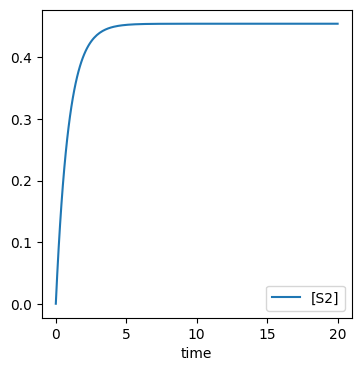

In [28]:
_ = plotModel(MODEL1, input_species="S1", times=np.linspace(0, 20, 200), parameter_dct={'S1': 1})

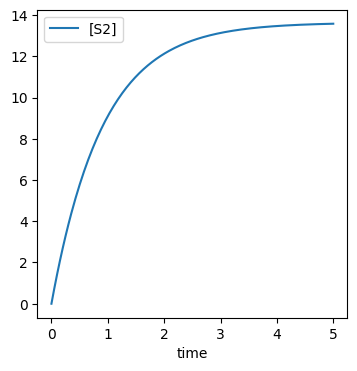

In [34]:
_ = plotModel(MODEL1, input_species="S1", times=np.linspace(0, 5, 200), parameter_dct={'S1': 30})

## An uncontrolable System

In [7]:
MODEL2 = """
S1 -> S2; k1*S1/(1 + S1)
S2 -> ; k2*S2
$S1 = 0
k1 = 0.5
k2 = 1.1
S2 = 0
"""

Find a value of S1 that results in S2 = 2.

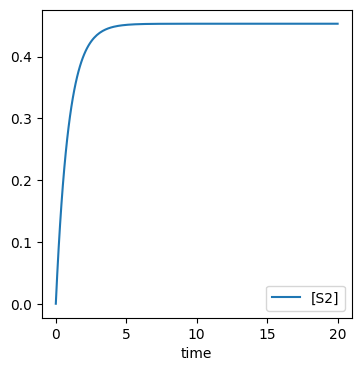

In [36]:
_ = plotModel(MODEL2, input_species='S1', times=np.linspace(0, 20, 200), parameter_dct={'S1': 300})

# mTOR Case Study



<img src="https://raw.github.com/joseph-hellerstein/advanced-controls-lectures/main/lectures/lecture_05-controllability/mtor.png"
     alt="Markdown Monster icon"
     width="1000" height="300"
     style="float: left; margin-right: 10px;" />

In [37]:
# mTOR model
MTOR_URL = "https://www.ebi.ac.uk/biomodels/services/download/get-files/MODEL1909250003/2/Varusai2018.xml"

Problem: What are the names of the species?

In [38]:
rr = te.loadSBMLModel(MTOR_URL)
rr.getFloatingSpeciesIds()

['IR',
 'pIR',
 'IRS',
 'pIRS',
 'iIRS',
 'Akt',
 'pAkt',
 'mTORC1',
 'pmTORC1',
 'mTORC2',
 'pmTORC2',
 'imTORC2',
 'mTORC1_DEPTOR',
 'mTORC2_DEPTOR',
 'DEPTOR',
 'pDEPTOR']

***Can we control mTORC1_DEPTOR in the range 150 to 200?***

<img src="https://github.com/joseph-hellerstein/advanced-controls-lectures/blob/main/lectures/lecture_05-controllability/mtor.png" width="300" height="225" /></a>


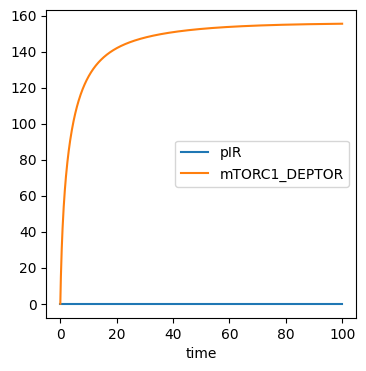

In [41]:
input_name = "pIR"
input_value = 0.1
_ = plotModel(MTOR_URL,  input_species=input_name, selections=[input_name, "mTORC1_DEPTOR"],
              parameter_dct={input_name: input_value}, times=np.linspace(0, 100, 1000))

We'll be doing this a lot. So, let's make a function.

In [12]:
def evaluateControlability(input_value:float, desired_output:float, is_plot:bool=True):
    # Plot TROC1_DEPTOR for different values of pIR as a fixed species
    #   input_value: float (setting for pIR)
    #   desired_output: float (desired value for mTORC1_DEPTOR)
    input_name = "pIR"
    end_time = 100
    _ = plotModel(MTOR_URL,  input_species=input_name, selections=[input_name, "mTORC1_DEPTOR"],
                  title=f"{input_name}: {input_value}",
                  parameter_dct={input_name: input_value}, times=np.linspace(0, end_time, 1000), is_plot=False)
    ax = plt.gca()
    ax.plot([0, end_time], [desired_output, desired_output], linestyle="--", color="red")
    if is_plot:
        plt.show()

#
evaluateControlability(1, 200, is_plot=False)
plt.close()
print("OK!")

OK!


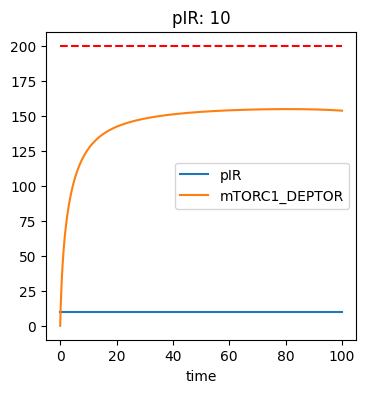

In [13]:
evaluateControlability(10, 200)

# Efficient Evaluation of Controllability

Look at the response to the input over a series of steps. The series of steps is called a **staircase**. A staircase has an initial value, a final value, and a number of steps. This is implemented by using Antimony **events**. An event is a statement executed once when a condition is true. We condition on the variable **time**.

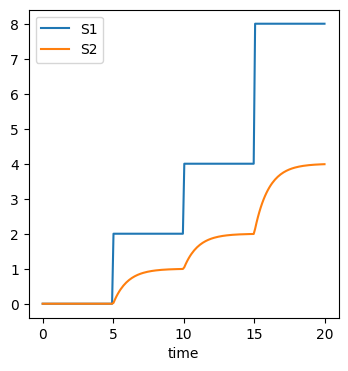

In [43]:
MODEL1A = """
model *main();
S1 -> S2; k1*S1
S2 -> ; k2*S2

S1 = 0
k1 = 0.5
k2 = 1
S2 = 0

// Events to create a staircase function of the input
at time > 0: S1 = 0
at time > 5: S1 = 2
at time > 10: S1 = 4
at time > 15: S1 = 8
end
"""
_ = plotModel(MODEL1A, times=np.linspace(0, 20, 200), input_species="S1", selections=["S1", "S2"])

This model has an operating region in which $S_1 \in [0, 8]$. That is, this range of input values elicit a significant change in the output $S_2$.

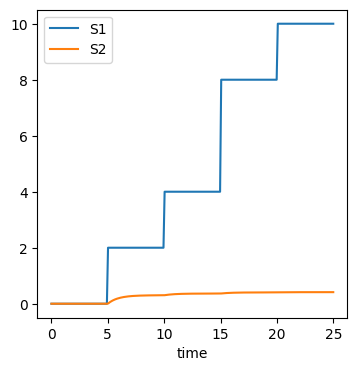

In [15]:
MODEL2A = """
model *main();
S1 -> S2; k1*S1/(1 + S1)
S2 -> ; k2*S2
$S1 = 0
k1 = 0.5
k2 = 1.1
S2 = 0

// Events to create a staircase function of the input
at time > 0: S1 = 0
at time > 5: S1 = 2
at time > 10: S1 = 4
at time > 15: S1 = 8
at time > 20: S1 = 10
end
"""
_ = plotModel(MODEL2A, times=np.linspace(0, 25, 250), input_species="S1", selections=["S1", "S2"], figsize=(4,4))

The operating region for this model is much smaller than the previous model. So, we need to adjust the staircase.

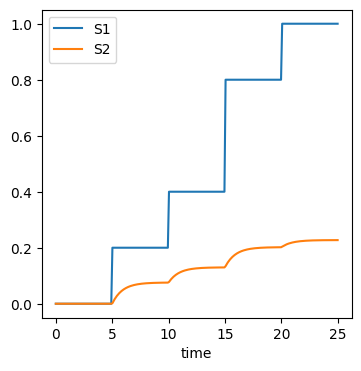

In [16]:
MODEL2B = """
model *main();
S1 -> S2; k1*S1/(1 + S1)
S2 -> ; k2*S2
$S1 = 0
k1 = 0.5
k2 = 1.1
S2 = 0

// Events to create a staircase function of the input
at time > 0: S1 = 0
at time > 5: S1 = 0.2
at time > 10: S1 = 0.4
at time > 15: S1 = 0.8
at time > 20: S1 = 1
end
"""
_ = plotModel(MODEL2B, times=np.linspace(0, 25, 250), input_species="S1", selections=["S1", "S2"], figsize=(4,4))

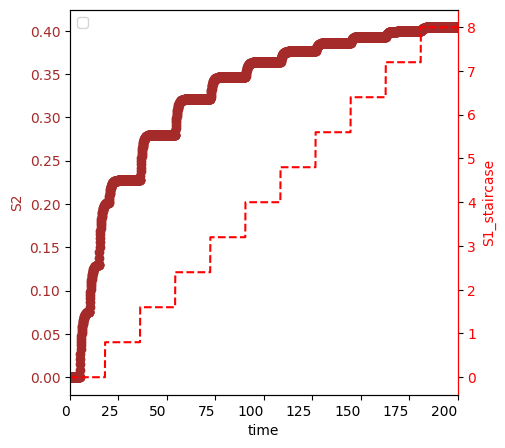

In [59]:
ctlsb = ctl.ControlSBML(MODEL2B, input_name="S1", output_name="S2", is_fixed_input_species=True)
_, builder = ctlsb.plotStaircaseResponse(initial_value=0, final_value=8, num_step=10, times=np.linspace(0, 200, 2000))

# Operating Region

The operating region of a system is the range of input values and corresponding range of output values over which the output values have a significant and predictable change.

**To specify an operating region**, you provide:
* Input species name, lower bound, upper bound
* Output species name, lower bound, upper bound
* Directional effect of an increase in the input species

# ControlSBML

In [56]:
MODEL4 = """
model *main();
S1 -> S2; k1*S1
S2 -> ; k2*S2

S1 = 0
k1 = 0.5
k2 = 10
S2 = 0
end
"""

## Getting ControlSBML

In [44]:
#!pip install controlSBML
import controlSBML as ctl
ctl.__version__

'1.2.3'

## Constructor

In [57]:
ctlsb = ctl.ControlSBML(MODEL4, input_name="S1", output_name="S2", is_fixed_input_species=True)

## Staircase

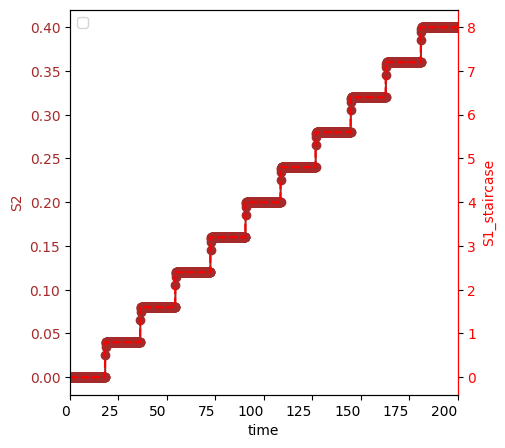

In [58]:
_, builder = ctlsb.plotStaircaseResponse(initial_value=0, final_value=8, num_step=10, times=np.linspace(0, 200, 2000))

In [21]:
builder

// Created by libAntimony v2.15.0
model *main()

  // Compartments and Species:
  species S1, S2;

  // Reactions:
  _J0: S1 -> S2; k1*S1;
  _J1: S2 -> ; k2*S2;

  // Species initializations:
  S1 = 0;
  S2 = 0;

  // Variable initializations:
  k1 = 1;
  k2 = 1;

  // Other declarations:
  const k1, k2;

//vvvvvvvvvAdded by ControlSBMLvvvvvvvvvv
const S1

// Staircase: S1->S2
S1 = 0.000000
at (time>= 0.0): S1 = 0.0
at (time>= 5.025125628140704): S1 = 2.6666666666666665
at (time>= 10.050251256281408): S1 = 5.333333333333333
at (time>= 15.075376884422111): S1 = 8.0
//^^^^^^^^^Added by ControlSBML^^^^^^^^^^
end

## mTOR Case Study

In [60]:
CTLSB = ctl.ControlSBML(MTOR_URL)

In [61]:
print(CTLSB.getPossibleOutputs())

floating_species:	IR, pIR, IRS, pIRS, iIRS, Akt, pAkt, mTORC1, pmTORC1, mTORC2, pmTORC2, imTORC2, mTORC1_DEPTOR, mTORC2_DEPTOR, DEPTOR, pDEPTOR

parameter:	V1, Km1, V2, Km2, k3c, Km3, V4, Km4, k5ca, Km5a, k5cb, Km5b, V6, Km6, k7c, Km7, V8, Km8, k9c, Km9, V10, Km10, k11ca, Km11a, k11cb, Km11b, V12, Km12, k13f, k13r, k14f, k14r, k15c, Km15, V16, Km16, ks17, kd18

reaction:	v1, v2, v3, v4, v5, v6, v7, v8, v9, v10, v11, v12, v13, v14, v15, v16, v17, v18


In [62]:
CTLSB = ctl.ControlSBML(MTOR_URL, input_name="pIR", output_name="mTORC1_DEPTOR", is_fixed_input_species=True)

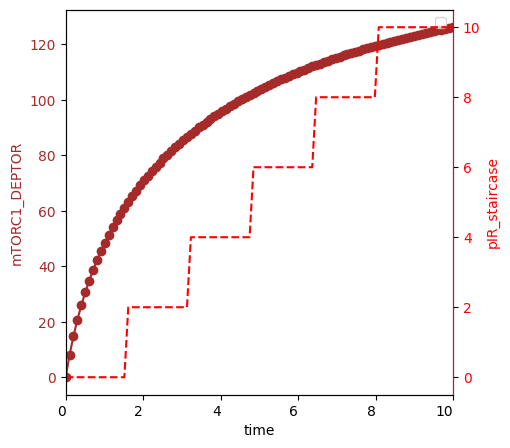

In [63]:
# First attempt at controllability analysis
_ = CTLSB.plotStaircaseResponse()

Are we really controlling ``mTORC1_DEPTOR``?

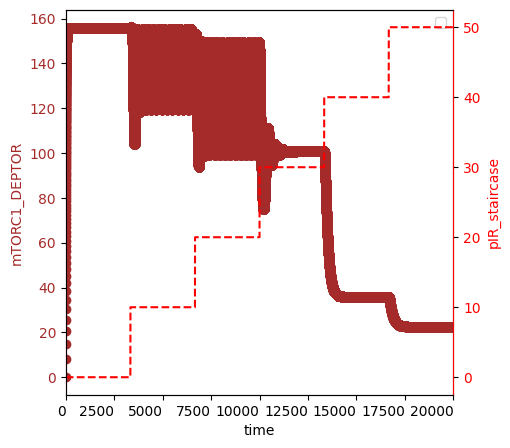

In [26]:
_ = CTLSB.plotStaircaseResponse(final_value=50, times=np.linspace(0, 20000, 200000))